# Shill Finding using ML
## Investigating shill dataset in order to find the optimal model for detection.

1. Problem Statement and metrics
2. EDA
3. Processing data and pipelines
4. Model training
5. Model tuning.
6. Model evaluation and reexamination
7. Testing model.


In [122]:
# Importing required libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score



In [56]:
df = pd.read_csv("Shill Bidding Dataset.csv") # importing dataset as df.

# 1. Problem statement:

## How do we detect shill bidders in online auctions?

Shill bidding is a fraudulent practice in online auctions where individuals knowingly or unknowingly collude with sellers to artificially inflate the price of an item. This is achieved through behaviors such as placing low initial bids to lure genuine participants, repeatedly increasing their own bids despite holding the highest bid, and abstaining from bidding at the auction's close to avoid winning.

This practice harms auction platforms, buyers, and legitimate sellers by eroding trust, increasing costs, and enabling criminal activity. Consequently, an effective detection system is essential to maintain the integrity of online auctions. An algorithm capable of detecting and flagging fraudulent bids could significantly reduce criminal revenues while protecting the interests of honest users.

## Solution

I propose training a machine learning (ML) algorithm to classify bids as either fraudulent (shill) or legitimate. By automating this detection process, platforms can identify suspicious activity in real-time or retrospectively. This would allow for preventive measures such as disallowing fraudulent bids or taking corrective actions, such as flagging or banning accounts involved in shill bidding.

## How to evaluate the results: What metrics are we interested in?

The success of the proposed algorithm hinges on the careful selection of evaluation metrics. Fraud detection involves a trade-off between classification outcomes: <br> 

True Positives (TP): Correctly identifying fraudulent bids.
True Negatives (TN): Correctly identifying legitimate bids.
False Positives (FP): Incorrectly labeling legitimate bids as fraudulent, leading to user dissatisfaction.
False Negatives (FN): Failing to detect fraudulent bids, undermining platform trust and allowing fraud to persist.


The following metrics should therefore be considered:

- Precision: <br>

$ \frac{TP}{TP+FP} $. <br>
    -Indicates the accuracy of positive predictions, minimizing false accusations.

- Recall: <br>

$ \frac{TP}{TP+FN} $ <br>
    -Measures the algorithm's ability to detect shill bidders, prioritizing the reduction of undetected fraud.

We must make a value judgement between recall and precision, prioritising either one over the other.  
If we consider them equally important we can use: <br>

- F1 score: <br> 
$F1=2⋅\frac{(Precision*Recall)}{(Precision+Recall)}$ <br>

## Choosing a metric

Given the high cost of missed fraud (FN), we will prioritize recall while maintaining a reasonable precision. Additional mechanisms, such as secondary checks on flagged bids or redoing the auction free of charge, can help mitigate the impact of false positives.

Resultantly we should balance precision and recall, with an emphasis of recall and limiting FN as they are deemed the most detrimental. We will ensure this balance by using AUC-ROC to measure the tradeoff between recall and the false positives at different thresholds. 

This will give us a measure of the models ability to distinguish between shill and legitimate bids. A high AUC indicates good serparation between fraud and non-fraud. 

## Note on unbalanced data
Shill bidding is a relatively rare occurrence (including this dataset), leading to imbalanced datasets where the majority of bids are legitimate. This imbalance can affect model performance, as classifiers may favor the majority class. For this reason, it is important not to determine performance from accuracy score alone. 

To address this, we will employ techniques such as SMOTE.....andthereforesuchas....


# EDA

Explanation of dataset features:

**Record ID:** Unique identifier of a record in the dataset. <br>
**Auction ID:** Unique identifier of an auction. <br>
**Bidder ID:** Unique identifier of a bidder. <br>
**Bidder Tendency:** A shill bidder participates exclusively in auctions of few sellers rather than a diversified lot. This is a collusive act involving the fraudulent seller and an accomplice. <br>
**Bidding Ratio:** A shill bidder participates more frequently to raise the auction price and attract higher bids from legitimate participants.<br>
**Successive Outbidding:** A shill bidder successively outbids himself even though he is the current winner to increase the price gradually with small consecutive increments.<br>
**Last Bidding:** A shill bidder becomes inactive at the last stage of the auction (more than 90% of the auction duration) to avoid winning the auction.<br>
**Auction Bids:** Auctions with SB activities tend to have a much higher number of bids than the average of bids in concurrent auctions.<br>
**Auction Starting Price:** a shill bidder usually offers a small starting price to attract legitimate bidders into the auction.<br>
**Early Bidding:** A shill bidder tends to bid pretty early in the auction (less than 25% of the auction duration) to get the attention of auction users.<br>
**Winning Ratio:** A shill bidder competes in many auctions but hardly wins any auctions.<br>
**Auction Duration:** How long an auction lasted.<br>
**Class:** 0 for normal behaviour bidding; 1 for otherwise.<br>


In [96]:
df.describe()

,Record_ID,Auction_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
count,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000
mean,7535.829457,1241.388230,0.142541,0.127670,0.103781,0.463119,0.231606,0.472821,0.430683,0.367731,4.615093,0.106787
std,4364.759137,735.770789,0.197084,0.131530,0.279698,0.380097,0.255252,0.489912,0.380785,0.436573,2.466629,0.308867
min,1.000000,5.000000,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3778.000000,589.000000,0.027027,0.043478,0.000000,0.047928,0.000000,0.000000,0.026620,0.000000,3.000000,0.000000
50%,7591.000000,1246.000000,0.062500,0.083333,0.000000,0.440937,0.142857,0.000000,0.360104,0.000000,5.000000,0.000000
75%,11277.000000,1867.000000,0.166667,0.166667,0.000000,0.860363,0.454545,0.993593,0.826761,0.851852,7.000000,0.000000
max,15144.000000,2538.000000,1.000000,1.000000,1.000000,0.999900,0.788235,0.999935,0.999900,1.000000,10.000000,1.000000


In [58]:
df.head()

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7,0


In [59]:
df.corr(numeric_only=True)

,Record_ID,Auction_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
Record_ID,1.000000,-0.003776,0.011075,-0.040123,0.005271,0.037588,0.048377,0.001265,0.031719,-0.057151,-0.012150,-0.003731
Auction_ID,-0.003776,1.000000,-0.006902,-0.021424,-0.003175,0.070341,0.097558,0.016182,0.068427,-0.039779,0.024918,-0.007985
Bidder_Tendency,0.011075,-0.006902,1.000000,0.293076,0.313510,0.044999,0.086564,0.073242,0.019978,0.212170,0.000244,0.295533
Bidding_Ratio,-0.040123,-0.021424,0.293076,1.000000,0.604828,-0.066541,-0.347831,-0.252289,-0.147773,0.642905,-0.019205,0.569435
Successive_Outbidding,0.005271,-0.003175,0.313510,0.604828,1.000000,0.098941,0.065361,0.052263,0.056798,0.382002,0.010091,0.901035
Last_Bidding,0.037588,0.070341,0.044999,-0.066541,0.098941,1.000000,0.297639,0.293323,0.950096,-0.076726,0.011454,0.097655
Auction_Bids,0.048377,0.097558,0.086564,-0.347831,0.065361,0.297639,1.000000,0.629086,0.298878,-0.381442,0.093331,0.044964
Starting_Price_Average,0.001265,0.016182,0.073242,-0.252289,0.052263,0.293323,0.629086,1.000000,0.302958,-0.262655,0.022990,0.042604
Early_Bidding,0.031719,0.068427,0.019978,-0.147773,0.056798,0.950096,0.298878,0.302958,1.000000,-0.137005,0.011296,0.053570
Winning_Ratio,-0.057151,-0.039779,0.212170,0.642905,0.382002,-0.076726,-0.381442,-0.262655,-0.137005,1.000000,-0.023965,0.394122


In [95]:
df.describe()
df["Auction_ID"].value_counts()

Auction_ID
589     26
1872    26
256     24
658     24
2498    23
        ..
1756     1
548      1
1971     1
458      1
2329     1
Name: count, Length: 807, dtype: int64

,Record_ID,Auction_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
Record_ID,1.000000,-0.003776,0.011075,-0.040123,0.005271,0.037588,0.048377,0.001265,0.031719,-0.057151,-0.012150,-0.003731
Auction_ID,-0.003776,1.000000,-0.006902,-0.021424,-0.003175,0.070341,0.097558,0.016182,0.068427,-0.039779,0.024918,-0.007985
Bidder_Tendency,0.011075,-0.006902,1.000000,0.293076,0.313510,0.044999,0.086564,0.073242,0.019978,0.212170,0.000244,0.295533
Bidding_Ratio,-0.040123,-0.021424,0.293076,1.000000,0.604828,-0.066541,-0.347831,-0.252289,-0.147773,0.642905,-0.019205,0.569435
Successive_Outbidding,0.005271,-0.003175,0.313510,0.604828,1.000000,0.098941,0.065361,0.052263,0.056798,0.382002,0.010091,0.901035
Last_Bidding,0.037588,0.070341,0.044999,-0.066541,0.098941,1.000000,0.297639,0.293323,0.950096,-0.076726,0.011454,0.097655
Auction_Bids,0.048377,0.097558,0.086564,-0.347831,0.065361,0.297639,1.000000,0.629086,0.298878,-0.381442,0.093331,0.044964
Starting_Price_Average,0.001265,0.016182,0.073242,-0.252289,0.052263,0.293323,0.629086,1.000000,0.302958,-0.262655,0.022990,0.042604
Early_Bidding,0.031719,0.068427,0.019978,-0.147773,0.056798,0.950096,0.298878,0.302958,1.000000,-0.137005,0.011296,0.053570
Winning_Ratio,-0.057151,-0.039779,0.212170,0.642905,0.382002,-0.076726,-0.381442,-0.262655,-0.137005,1.000000,-0.023965,0.394122


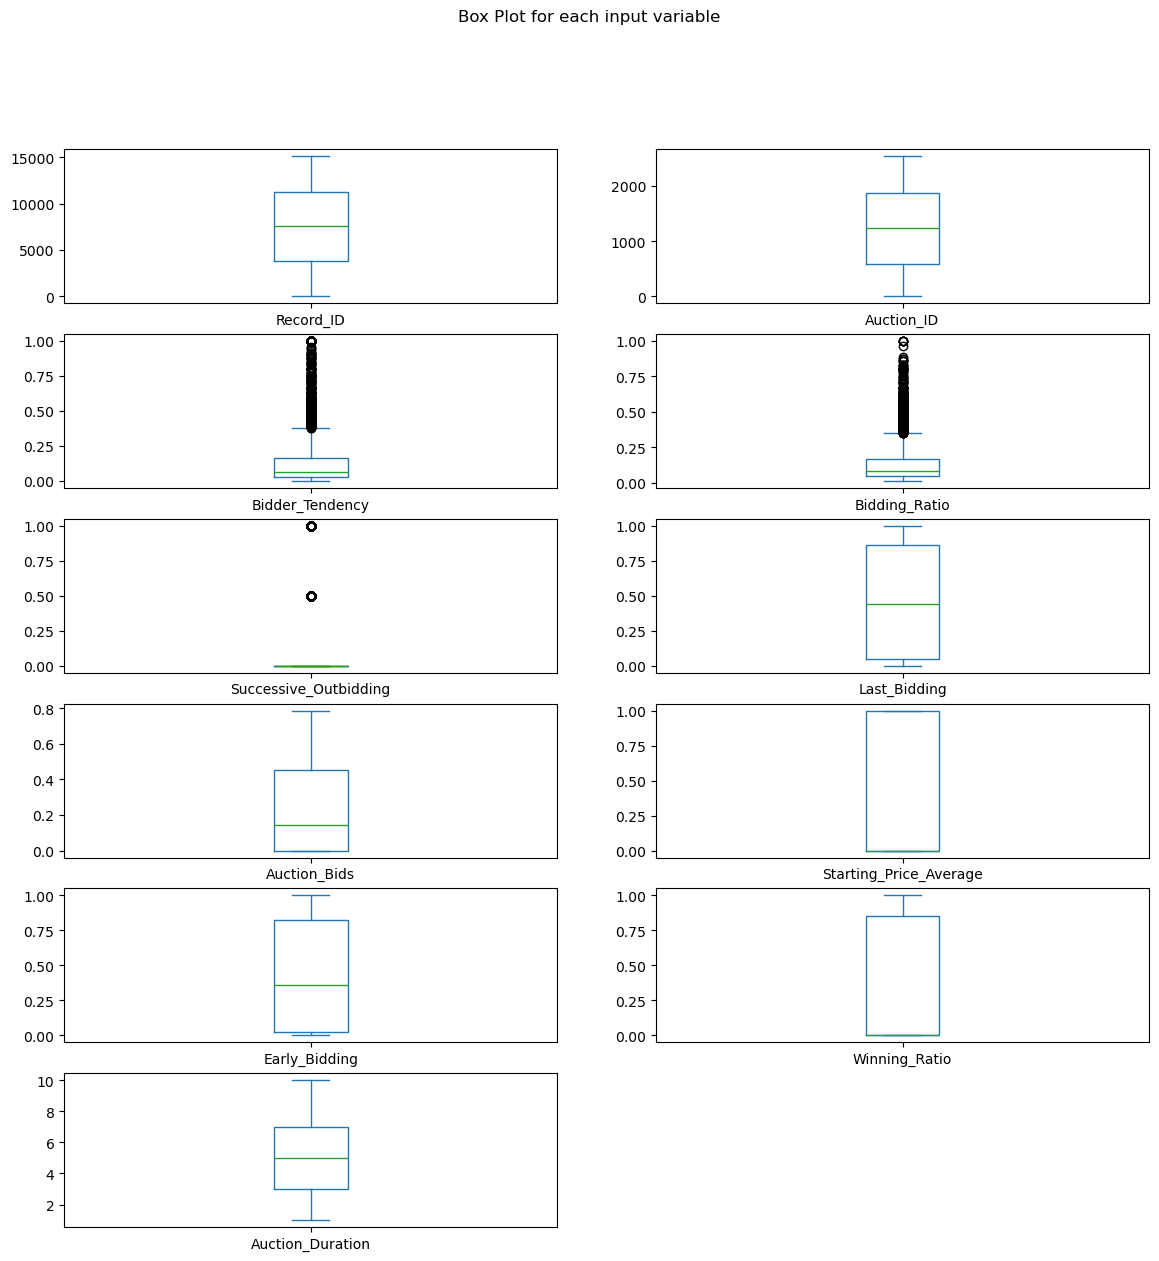

In [65]:
df.drop('Class', axis=1).plot(kind='box', subplots=True, layout=(6,2), sharex=False, sharey=False, figsize=(14,14), title='Box Plot for each input variable')
plt.show()

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


Text(0, 0.5, 'Probability Density')

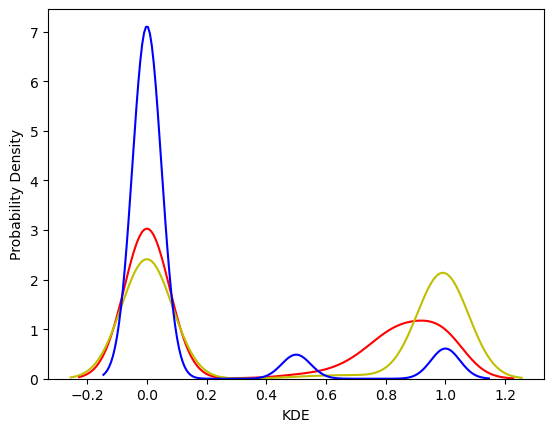

In [81]:
print(sns.kdeplot(data=df, x='Winning_Ratio', color='r'))
print(sns.kdeplot(data=df, x='Starting_Price_Average', color='y'))
print(sns.kdeplot(data=df, x='Successive_Outbidding', color='b'))

plt.xlabel('KDE')
plt.ylabel('Probability Density')

In [75]:
df.drop("Bidder_ID", axis=1)


,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6316,15129,760,l***t,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889,3,1
6317,15137,2481,s***s,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788,7,0
6318,15138,2481,h***t,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000,7,0
6319,15139,2481,d***d,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000,7,0


In [103]:
df.groupby("Auction_ID")["Class"].sum()
df.loc[df["Auction_ID"]==5]

1.000000001

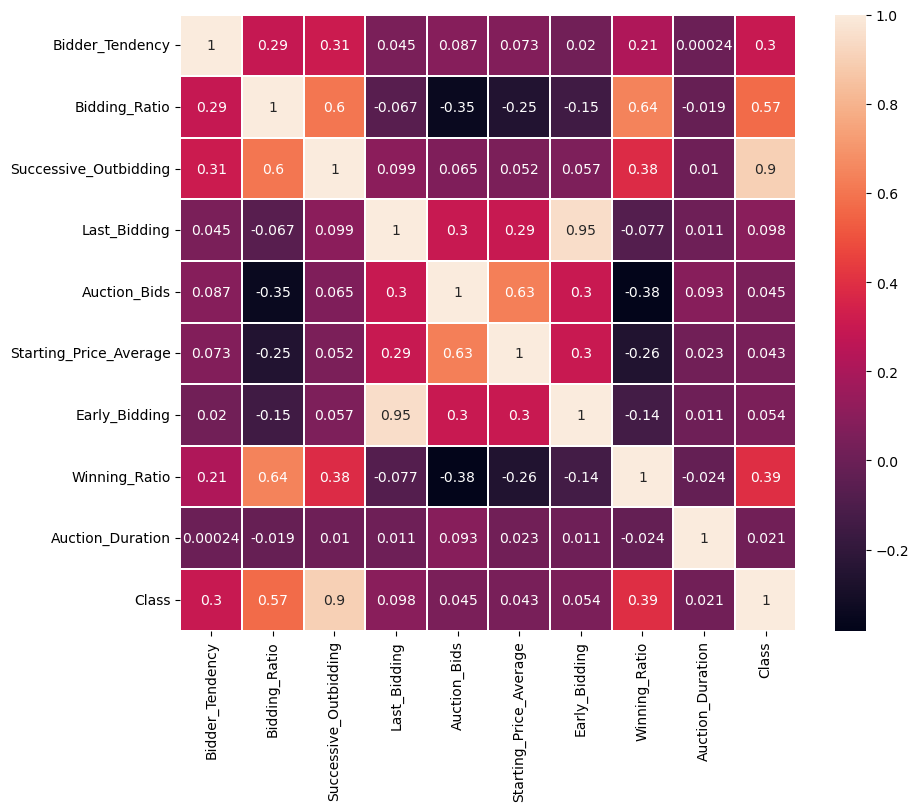

In [82]:
# creating a corr plot to help understand relationships
plt.figure(figsize=(10,8))
sns.heatmap(df.drop(columns=["Bidder_ID","Record_ID", "Auction_ID"], axis=1).corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)
plt.show()

Successive_Outbidding
0.0    5478
1.0     469
0.5     374
Name: count, dtype: int64

## Exploring Models

From our EDA we made the following observations. 

1. The column values are generally between 0,1. No scaling nescessary. These columns are ['Bidder_Tendency', 'Successive_Outbidding', 'Last_Bidding', 'Starting_Price_Average',
       'Early_Bidding', 'Winning_Ratio']
       
       We should however consider "Successive Outbidding since it only consits of 0,0,5 and 1 as values. 
   
2. Some columns require scaling. ['Auction_Bids', 'Auction_Duration', 'Bidding_Ratio']. We choose MinMaxScaler. 



In [89]:
X = df.drop(columns=["Class", "Bidder_ID", "Auction_ID", "Record_ID"]) 
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [104]:
X.describe()

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration
count,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000,6321.000000
mean,0.142541,0.127670,0.103781,0.463119,0.231606,0.472821,0.430683,0.367731,4.615093
std,0.197084,0.131530,0.279698,0.380097,0.255252,0.489912,0.380785,0.436573,2.466629
min,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.027027,0.043478,0.000000,0.047928,0.000000,0.000000,0.026620,0.000000,3.000000
50%,0.062500,0.083333,0.000000,0.440937,0.142857,0.000000,0.360104,0.000000,5.000000
75%,0.166667,0.166667,0.000000,0.860363,0.454545,0.993593,0.826761,0.851852,7.000000
max,1.000000,1.000000,1.000000,0.999900,0.788235,0.999935,0.999900,1.000000,10.000000


In [123]:
classifier_scale = [SVC(), KNeighborsClassifier()]
classifier_not_scale = [DecisionTreeClassifier(), RandomForestClassifier()]


#Preprocessing step: imputing, scaling and encoding data.

scale_features = ['Auction_Bids', 'Auction_Duration', 'Bidding_Ratio']

pass_features = ['Bidder_Tendency', 'Last_Bidding', 'Starting_Price_Average',
       'Early_Bidding', 'Winning_Ratio','Successive_Outbidding']



scaler = MinMaxScaler()
num_transformer = make_pipeline(scaler)
preprocessor = make_column_transformer((num_transformer, scale_features), ("passthrough",pass_features))

In [124]:
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Auction_Bids', 'Auction_Duration',
                                  'Bidding_Ratio']),
                                ('passthrough', 'passthrough',
                                 ['Bidder_Tendency', 'Last_Bidding',
                                  'Starting_Price_Average', 'Early_Bidding',
                                  'Winning_Ratio', 'Successive_Outbidding'])])

In [115]:
for classifier in classifier_scale:
    pipe = make_pipeline(preprocessor, classifier)
    grid = GridSearchCV(estimator = pipe, param_grid={}, cv=5, scoring="precision")
    grid.fit(X_train, y_train)
    print(f"Best precision score for {classifier}: {grid.best_score_}")
    
for classifier in classifier_not_scale:
    pipe = make_pipeline(preprocessor, classifier)
    grid = GridSearchCV(estimator = pipe, param_grid={}, cv=5, scoring="precision")
    grid.fit(X_train, y_train)
    print(f"Best precision score for {classifier}: {grid.best_score_}")
    

Best precision score for SVC(): 0.8898196079069123
Best precision score for KNeighborsClassifier(): 0.933120502077162
Best precision score for DecisionTreeClassifier(): 0.9828155521175859
Best precision score for RandomForestClassifier(): 0.9520467813914417


## Choosing RandomForestClassifier()


In [121]:
# We look at the cross fold validation score for RF. 

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Auction_Bids', 'Auction_Duration',
                                  'Bidding_Ratio']),
                                ('passthrough', 'passthrough',
                                 ['Bidder_Tendency', 'Last_Bidding',
                                  'Starting_Price_Average', 'Early_Bidding',
                                  'Winning_Ratio']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['Successive_Outbidding'])])

In [41]:

cols = X
scaler = StandardScaler()
classifier = RandomForestClassifier()
pipe = make_pipeline(scaler, classifier)



In [42]:
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [117]:
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(pipe, X_train, y_train, cv=5, scoring ="precision")

print(f"Cross fold scores: {cv_score} \n Cross fold avg is: {cv_score.mean()}")

Cross fold scores: [0.95238095 0.91071429 0.97169811 0.98095238 0.93693694] 
 Cross fold avg is: 0.9505365338384207


In [49]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [70]:
df['Successive_Outbidding'].value_counts()

Successive_Outbidding
0.0    5478
1.0     469
0.5     374
Name: count, dtype: int64

In [68]:
df['Winning_Ratio'].value_counts()

Winning_Ratio
0.000000    3640
1.000000     826
0.750000     143
0.833333     110
0.666667     107
            ... 
0.950000       5
0.913043       5
0.615385       3
0.400000       3
0.625000       2
Name: count, Length: 72, dtype: int64

In [69]:
df['Starting_Price_Average'].value_counts()

Starting_Price_Average
0.000000    3253
0.993593    1921
0.999935     345
0.993528     322
0.935346      89
0.676405      48
0.999353      43
0.998900      36
0.987121      34
0.825259      29
0.967640      29
0.935281      26
0.676469      24
0.961233      23
0.514607      22
0.935605      15
0.546967      15
0.553050      15
0.995146      13
0.967705      11
0.805843       5
0.929586       3
Name: count, dtype: int64

In [48]:
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [120]:
pipe

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])

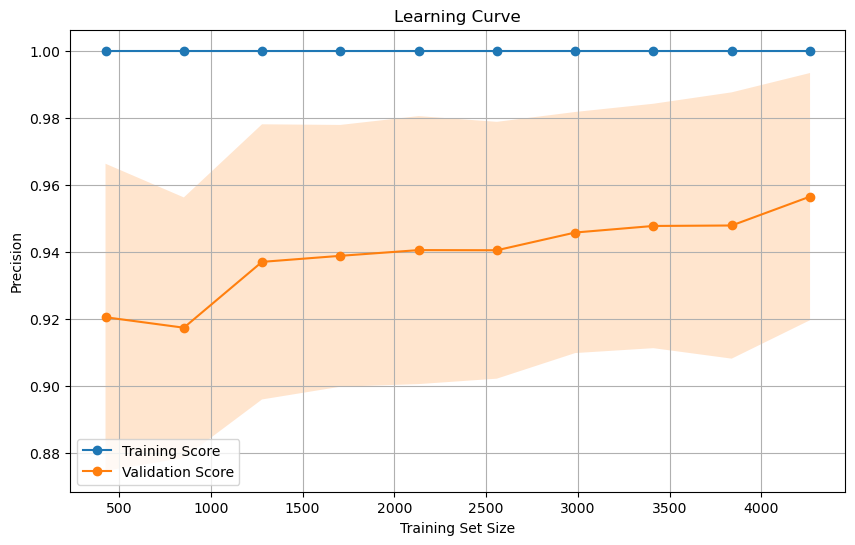

In [119]:
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    pipe, X_train, y_train, cv=10, scoring='precision', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.plot(train_sizes, val_scores_mean, label="Validation Score", marker='o')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Precision")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

 Accuracy: 1.0


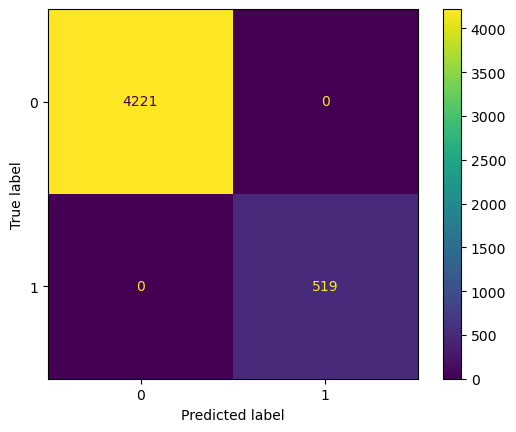

In [50]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train,y_pred)

print(f" Accuracy: {accuracy}")
ConfusionMatrixDisplay.from_estimator(pipe,X_train,y_train)
plt.show()

In [83]:
X

,Record_ID,Auction_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration
0,1,732,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667,5
1,2,732,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444,5
2,3,732,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000,5
3,4,732,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000,5
4,5,900,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000,7
...,...,...,...,...,...,...,...,...,...,...,...
6316,15129,760,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889,3
6317,15137,2481,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788,7
6318,15138,2481,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000,7
6319,15139,2481,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000,7


In [ ]:
classifier_scale = [SVC(), KNeighborsClassifier()]
regressors_not_scale = [DecisionTreeClassifier(), RandomForestClassifier()]


#Preprocessing step: imputing, scaling and encoding data.

scale_features = ['list_fee', 'sqm','distance_to_central_station']

pass_features = ['rooms', 'balcony', 'gardet', 'kungsholmen',
       'norrmalm', 'ostermalm', 'sodermalm', 'vasastan', 'latitude', "longitude"]


scaler1 = StandardScaler()
num_transformer = make_pipeline(scaler1)

encoder = OneHotEncoder()
cat_transformer = encoder
preprocessor = make_column_transformer((num_transformer, num_features), ("passthrough",pass_features))

In [ ]:
for classifier in classifier_scale:
    pipe = make_pipeline(scaler1, regressor)
    grid = GridSearchCV(estimator = pipe, param_grid={}, cv=5, scoring="neg_mean_absolute_error")
    grid.fit(X_train, y_train)
    print(f"Best r2 score for {regressor}: {grid.best_score_}")
    
for regressor in regressors_not_scale:
    pipe = make_pipeline(regressor)
    grid = GridSearchCV(estimator = pipe, param_grid={}, cv=5, scoring="neg_mean_absolute_error")
    grid.fit(X_train, y_train)
    print(f"Best r2 score for {regressor}: {grid.best_score_}")